# Algebarski i optimizacioni pristup linearnoj regresiji

U ovoj svesci ćemo prvo ponoviti kreiranje sintetičkog skupa podataka iz prethodnog primera, a potom ispitati i algebarski i optimizacioni pristup problemu linearne regresije.

In [1]:
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics

In [3]:
np.random.seed(7)

Nadalje ce biti posmatran problem linearne regresije sa modelom $f(x) = \beta_0 + \beta_1x$. Skup podataka sa kojim ćemo raditi će biti sintetički. Vrednosti atributa će biti podeoci ekvidistantne mreže na intervalu [1, 5], a vrednosti ciljne funkcije će biti generisane po formuli $y = 11\cdot sin(x)$ uz dodatak šuma. 

In [4]:
N = 100

In [5]:
x = np.linspace(1, 5, N).reshape(N, 1)
y = 11*np.sin(x) + 1.5* np.random.randn(N, 1)

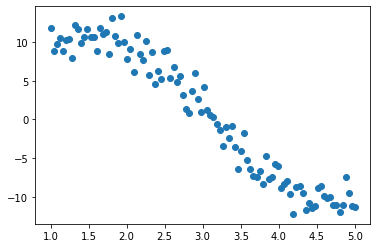

In [6]:
plt.plot(x, y, 'o')
plt.show()

In [7]:
model = linear_model.LinearRegression()

In [8]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.4, random_state = 7)

In [9]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
b1 = model.coef_[0][0]

In [11]:
b0 = model.intercept_[0]

In [12]:
print('Koeficijenti modela: ', b0, b1)

Koeficijenti modela:  21.09523191378001 -6.888382319483821


## Algebarski pristup linearnoj regresiji

Umesto korišćenja ugrađenih funkcija `scikit-learn` biblioteke, do rešenja smo mogli stići i koristeći algebarski aparat rešavajući jednačinu normale.

### Postavka problema 

Potrebno je rešiti matričnu jednačinu $X\beta=Y$  tj. $X^TX\beta=X^TY$ u kojoj je $X$ matrica podataka, a $Y$ kolona sa vrednostima ciljne promenljive. Da bi se ovaj sistem rešio potrebno je izračunati `Mur-Penrouzov inverz` tj. matricu $(X^TX)^{-1}X^T$. Složenost izračunavanja ovog inverza matrice je $O(k^3)$ gde je $k$ broj atibuta koji se koristi za opisivanje skupa podataka. Matrica $P=X(X^TX)^{-1}X^T$ se zove matrica predikcije jer proizvod $PX$ daje ocene ciljne promenljive $Y$.
<br>
<br>
Neke od osobina koje matrica predikcije ima: 
<br> 
* matrica je simetrična
* matrica je idempotentna tj. važi PP = P

Promenljiva `train_size` će predstavljati veličinu skupa za treniranje.

In [13]:
train_size = x_train.shape[0]
train_size

60

Matrica podataka će imati i jednu dodatnu kolonu sa jedinicama koje odgovaraju množenjima sa slobodnim koeficijentom $\beta_0$ u skupu parametara $\beta$.

In [14]:
M = np.vstack([np.ones(train_size), x_train.ravel()]).transpose()

In [15]:
M.shape

(60, 2)

Mur-Prenrouzov inverz se može izračunati koristeći funkciju `pinv` paketa `linalg` biblioteke NumPy.

In [16]:
coef_pseudo = np.linalg.pinv(M).dot(y_train)

In [17]:
coef_pseudo.shape

(2, 1)

In [18]:
coef_pseudo

array([[21.09523191],
       [-6.88838232]])

In [19]:
print('Koeficijenti modela: ', coef_pseudo[0][0], coef_pseudo[1][0])

Koeficijenti modela:  21.09523191378004 -6.888382319483825


Primetimo da se ovako dobijeni koeficijenti poklapaju sa koeficijentima koje smo dobili bibliotečkim rešavanjem.

Prilikom primena algebarskih metoda treba voditi računa o `dimenzionalnosti problema` i o `uslovljenosti` matrice podataka. 

Dimenzionalnost problema utiče na vremenske i memorijske zahteve, a uslovljenost na numeričku stabilnost rešenja. Ukoliko male promene u podacima vode do velikih promena rešenja, za sisteme kažemo da su numerički nestabilni. Ilustrujmo to malim primerom nad matricom `A` i vektorom `c`.

In [20]:
A = np.array([[1, 2], [2, 3.999]])
c = np.array([4, 7.999])

Rešenje sistema `Ax=c` se može pronaći korišćenjem bibliotečke funkcije `lstsq` paketa `linalg`. Izračunato rešenje se može pročitati kao prva povratna vrednost. 

In [21]:
solution, _, _, _ = np.linalg.lstsq(A, c, rcond=None)

In [22]:
solution

array([2., 1.])

Ukoliko malo promenimo vrednost vektora `c`, rešenje će se značajno promeniti.

In [23]:
c_modified = np.array([4, 7.998])

In [24]:
solution_modified, _, _, _ = np.linalg.lstsq(A, c_modified, rcond=None)

In [25]:
solution_modified

array([-1.98642461e-16,  2.00000000e+00])

Ovakvo ponašanje je posledica loše uslovljenosti matrice `A`. Uslovljenost matrice predstavlja vrednost $cond(A)=||A||\cdot||A^{-1}||$ koja se kreće u opsegu od $[1, +\infty]$ i što je veća matrica je lošije uslovljena.

In [26]:
np.linalg.cond(A)

24992.000960058016

Ukoliko među podacima imamo korelisane atribute, uslovljenost matrice će biti velika, a samim tim izračunavanje će biti numerički nestabilnije. 

In [27]:
x1 = np.random.randint(0, 20, 50)
x2 = np.random.randint(0, 5, 50)
x3 = 2*x1

X_train = np.vstack([np.ones(50), x1, x2, x3]).transpose()

In [28]:
np.linalg.cond(X_train)

4.536981679385349e+16

Na ovaj problem ćemo se osvrnuti i u svesci koja se tiče korelacije atributa i upoznati neke tehnike kako da ova ponašanja iskontrolišemo. 

## Optimizacioni pristup problemu linearne regresije

`Gradientni spust` je optimizacioni metod kojim se iterativno dolazi do optimuma, minimuma ili maksimuma, funkcije. U slučaju minimizacije funkcije, prate se suprotni pravci gradijenta duž kojih vrednosti funkcije najviše opadaju. 
<br> 

Neka je $f(x)$ funkcija jedne pormenljive čiji se minimu traži i neka je $x_0$ proizvoljno odabrana tačka. Korak iteracije gradijentnog spusta određen je sa $x_{k+1} = x_k - \alpha\nabla f(x_k)$ za $k=0,1,...$. Parametar $\alpha$ se naziva `korak učenja`. 


<br>

Važna pitanja u vezi sa gradijentnim spustom su: 
* Pod kojim uslovima uočeni algoritam konvergira?
* Na koji način se bira korak učenja?
* Kada zaustaviti algoritam? 
* Na koji način se bira početna tačka $x_0$?

Ukoliko se kao zaustavni kriterijum odaberu maksimalni broj iteracija i tačnost rešenja, za funkciju `f` jedne promenljive sa gradijentom `grad` i početnom tačkom `x`, gradijentni spust se može zapisati na sledeći način.

In [29]:
def gradient_descent(f, grad, x, alpha, eps, max_iterations):
    result = {}
    
    x_old = x 
    for i in range(0, max_iterations):
        x_new = x_old - alpha*grad(x_old)
        if np.abs(f(x_new)-f(x_old)) < eps:
            break;
        x_old = x_new
    
    result['converge'] = i != max_iterations
    result['number_of_iterations'] = i
    result['x_min'] = x_old
    
    return result

Pre primene metode gradijentnog spusta na problem linearne regresije, možemo proći kroz jedan mali uvodni primer u kojem je korišćenjem gradijentnog spusta potrebno odrediti minimum funkcije $f(x_1, x_2) = \frac{1}{2}(x_1^2 + 10x_2^2)$. Za korak učenja možemo uzeti $\alpha = 0.1$, za preciznost vrednost $eps = 0.01$, a broj iteracija ograničiti na $1000$.  

Funkcijom `f` ćemo predstaviti zadatu funkciju $f(x_1, x_2) = \frac{1}{2}(x_1^2 + 10x_2^2)$.

In [30]:
def f(x):
    x1 = x[0]
    x2 = x[1]
    return 0.5*(x1**2 + 10*x2**2)

Funkcijom `grad` ćemo predstaviti gradijent funkcije $\nabla f(x_1, x_2) = [x_1, 10x_2]$.

In [31]:
def grad(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([x1, 10*x2])

In [32]:
x0 = (3, 5)
alpha = 0.1 
eps = 0.01 
max_iterations = 1000

In [33]:
result = gradient_descent(f, grad, x0, alpha, eps, max_iterations)

In [34]:
result

{'converge': True,
 'number_of_iterations': 22,
 'x_min': array([0.29543127, 0.        ])}

In [35]:
f_min = f(result['x_min'])

In [36]:
f_min

0.043639817840438584

In [37]:
result['number_of_iterations']

22

U kontekstu razmatranog problema linearne regresije, funkcija koja se minimizuje je funkcija greške. Njen oblik je $\frac{1}{2} \frac{1}{N} \sum_{i=1}^{N} (\beta_0 + \beta_1x_i -y_i)^2$ (faktor $\frac{1}{2}$ je dodat zbog finijih formi gradijenata i kozmetičke je prirode, ne menja vrednosti očekivanih minimuma).

In [38]:
def error_function(beta, x, y):
    beta0 = beta[0]
    beta1 = beta[1]
    
    return 0.5*np.average((beta0 + beta1*x - y)**2)

Minimizacija funkcije greške se radi po parametrima $\beta_0$ i $\beta_1$. Zato će nam biti potreban i gradijent funkcije greške po ovim parametrima. Može se proveriti da je to vektor $[\frac{1}{N} \sum_{i=1}^{N}(\beta_0+\beta_1x_i-y_i), \frac{1}{N} \sum_{i=1}^{N}(\beta_0+\beta_1x_i-y_i)\cdot x_i]$. 

Sam kod će pratiti prethodni primer uz prilagođavanje izračunavanjima za dve promenljive. Uz ovo, da bismo mogli da vizualizujemo funkciju greške i njenu minimizaciju, čuvaćemo greške koje se dobijaju u pojedinačnim iteracijama.

In [39]:
def regression_gradient_descent(x, y, error_function, beta, alpha, eps, max_iterations, plot = False):
        
    result = {} 
        
    beta0_old = beta[0]
    beta1_old = beta[1]
    
    error_old = error_function((beta0_old, beta1_old), x, y)
    
    errors = np.empty(0)
    errors = np.append(errors, error_old)
    
        
    for i in np.arange(0, max_iterations):
            
        beta0_update = np.average(beta0_old + beta1_old*x -y)
        beta1_update = np.average((beta0_old + beta1_old*x -y)*x)
                
        beta0_new = beta0_old - alpha*beta0_update
        beta1_new = beta1_old - alpha*beta1_update
            
        error_new = error_function((beta0_new, beta1_new), x, y)
       
        
        if np.abs(error_new - error_old) < eps:
            break
                
        beta0_old = beta0_new
        beta1_old = beta1_new
        
        error_old = error_new
        
        errors = np.append(errors, error_new)
    
                
    result['converge'] = i != max_iterations
    result['number_of_iterations'] = i
    result['b_min'] = (beta0_old, beta1_old)
    
    if plot == True:
        plt.title('Funkcija greske')
        plt.xlabel('Broj iteracija')
        plt.ylabel('Srednjekvadratna greska')
        plt.plot(np.arange(0, i+1), errors)
    
    return result
            

Početno rešenje ćemo odabrati nasumično.

In [40]:
beta = (3, 1)
alpha = 0.1 
eps = 0.0001 
max_iterations = 1000

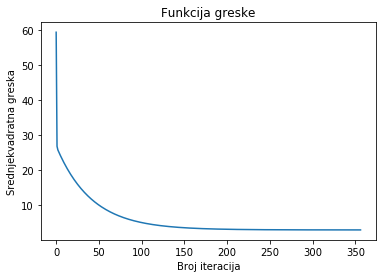

In [41]:
result = regression_gradient_descent(x, y, error_function, beta, alpha, 0.0001, max_iterations, plot=True)

In [42]:
result

{'converge': True,
 'number_of_iterations': 356,
 'b_min': (21.183938032983725, -6.8346663661553615)}

Rešenje koje dobijamo optimizacijom je:

In [43]:
result['b_min']

(21.183938032983725, -6.8346663661553615)

Kao što vidimo, i ovo rešenje se poklapa sa rešenjima koje smo do sada dobijali.

<div class='alert alert-info'>
Zadatak za vežbu. 
    
Pokušajte sa vektorskom implementacijom funkcije za računanje gradijentnog spusta za opšti slučaj linearne regresije.
</div>